In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
# 1. Carrega os dados
df = pd.read_csv('data.csv')

# 2. Define features e alvo
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo']
df['target'] = (df['popularity'] > 70).astype(int)

# 3. Remove linhas com dados em falta
df_clean = df.dropna(subset=features + ['target'])

# 4. Cria features combinadas
df_clean['dance_loud'] = df_clean['danceability'] * df_clean['loudness']
df_clean['acoustic_valence'] = df_clean['acousticness'] * df_clean['valence']

features_final = features + ['dance_loud', 'acoustic_valence']

X = df_clean[features_final].values
y = df_clean['target'].values

# 5. Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Treino/teste split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# 7. Aplica SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [20]:
# 8. Treina modelo XGBoost
clf_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=len(y_train_res)/sum(y_train_res),
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
clf_xgb.fit(X_train_res, y_train_res)

# 9. Previsões de probabilidade
y_probs_xgb = clf_xgb.predict_proba(X_test)[:, 1]


/opt/miniconda3/envs/ML/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:51:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_48ydvcv9e5/croot/xgboost-split_1748329884729/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [21]:
# 10. Loop de thresholds com barra de progresso
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results_xgb = []

print("\nAjustando thresholds no XGBoost com barra de progresso:")
for threshold in tqdm(thresholds, desc="Testando thresholds"):
    y_pred_adjusted = (y_probs_xgb >= threshold).astype(int)
    
    # Calcula métricas
    report = classification_report(y_test, y_pred_adjusted, output_dict=True)
    f1_hit = report['1']['f1-score']
    recall_hit = report['1']['recall']
    precision_hit = report['1']['precision']
    accuracy = report['accuracy']
    
    results_xgb.append({
        'Threshold': threshold,
        'F1-hit': f1_hit,
        'Recall-hit': recall_hit,
        'Precision-hit': precision_hit,
        'Accuracy': accuracy
    })


Ajustando thresholds no XGBoost com barra de progresso:


Testando thresholds: 100%|██████████| 9/9 [00:00<00:00, 165.61it/s]



Resultados do XGBoost por threshold:
   Threshold    F1-hit  Recall-hit  Precision-hit  Accuracy
0        0.1  0.079031    0.969438       0.041195  0.458498
1        0.2  0.093666    0.936430       0.049298  0.565673
2        0.3  0.105156    0.883863       0.055904  0.639477
3        0.4  0.118128    0.847188       0.063491  0.696845
4        0.5  0.128824    0.782396       0.070191  0.746389
5        0.6  0.145108    0.726161       0.080608  0.794937
6        0.7  0.166258    0.662592       0.095054  0.840731
7        0.8  0.196171    0.557457       0.119029  0.890510
8        0.9  0.223821    0.342298       0.166271  0.943102


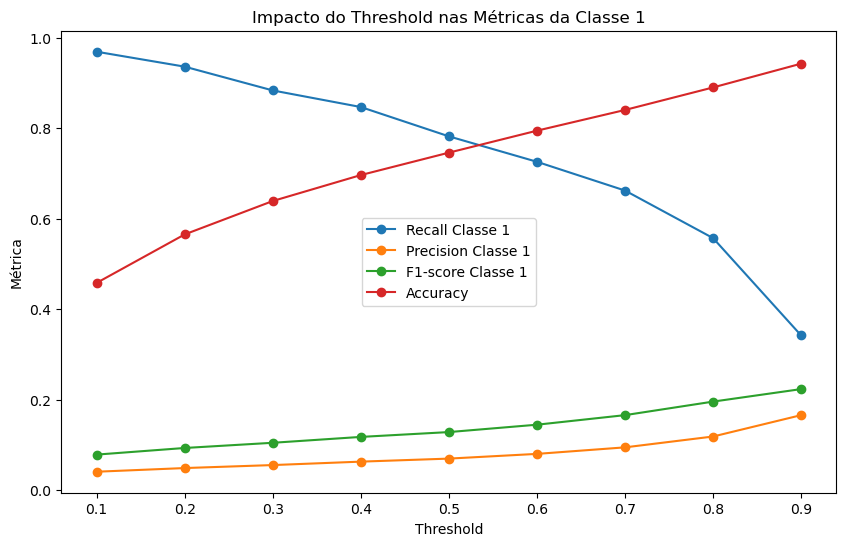

In [26]:
# 11. Mostra resultados em tabela
df_results_xgb = pd.DataFrame(results_xgb)
print("\nResultados do XGBoost por threshold:")
print(df_results_xgb)

# 12. Visualiza evolução do recall e f1-score
plt.figure(figsize=(10, 6))
plt.plot(df_results_xgb['Threshold'], df_results_xgb['Recall-hit'], marker='o', label='Recall Classe 1')
plt.plot(df_results_xgb['Threshold'], df_results_xgb['Precision-hit'], marker='o', label='Precision Classe 1')
plt.plot(df_results_xgb['Threshold'], df_results_xgb['F1-hit'], marker='o', label='F1-score Classe 1')
plt.plot(df_results_xgb['Threshold'], df_results_xgb['Accuracy'], marker='o', label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('Impacto do Threshold nas Métricas da Classe 1')
plt.legend()
plt.show()